# SIAMESE NETS

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

from src.features.TripletGenerator import TripletGenerator
from src.features.loss_functions import triplet_loss, identity_loss
from src.models.base_model import base_model
from src.models.siamese_model import siamese_model

In [59]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

In [60]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [61]:
with open('../data/processed/pure_data.pkl', 'rb') as data_file:
    df = pickle.load(data_file)
X_train, X_test, y_train, y_test = df

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2153, 7), (539, 7), (2153,), (539,))

In [62]:
sent_emb = 7
batch_size = 128
lr = 0.001
EPOCHS = 30
alpha = 0.2 

tgen = TripletGenerator()
train_generator = tgen.generate_triplets(X_train, y_train, batch_size)
test_generator = tgen.generate_triplets(X_test, y_test, batch_size)

labels = np.unique(np.concatenate([y_train, y_test]))
emb_model = base_model(sent_emb)
model = siamese_model(emb_model, sent_emb, triplet_loss, identity_loss, learning_rate=lr)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 7)            7943        input_10[0][0]                   
                                                                 input_11[0][0]             

In [63]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=EPOCHS, 
                              verbose=1, 
                              workers=5,
                              use_multiprocessing=True,
                              steps_per_epoch=20, 
                              validation_steps=30)

Epoch 1/30
20/20 [==============================] - 5s 197ms/step - loss: 11862.4159 - val_loss: 132.8496
Epoch 2/30
20/20 [==============================] - 3s 149ms/step - loss: 3593.9541 - val_loss: 43.6174
Epoch 3/30
20/20 [==============================] - 4s 212ms/step - loss: 1770.0620 - val_loss: 36.9818
Epoch 4/30
20/20 [==============================] - 3s 161ms/step - loss: 1026.3826 - val_loss: 24.3942
Epoch 5/30
20/20 [==============================] - 3s 160ms/step - loss: 694.5561 - val_loss: 16.1344
Epoch 6/30
20/20 [==============================] - 3s 159ms/step - loss: 473.6210 - val_loss: 10.7584
Epoch 7/30
20/20 [==============================] - 3s 167ms/step - loss: 384.6282 - val_loss: 8.2603
Epoch 8/30
20/20 [==============================] - 3s 173ms/step - loss: 329.9203 - val_loss: 5.1511
Epoch 9/30
20/20 [==============================] - 3s 160ms/step - loss: 236.8020 - val_loss: 3.7205
Epoch 10/30
20/20 [==============================] - 3s 145ms/step - l

Epoch 25/30
20/20 [==============================] - 3s 155ms/step - loss: 26.5912 - val_loss: 0.0100
Epoch 26/30
20/20 [==============================] - 3s 147ms/step - loss: 29.0609 - val_loss: 0.0100
Epoch 27/30
20/20 [==============================] - 3s 148ms/step - loss: 25.7851 - val_loss: 0.0100
Epoch 28/30
20/20 [==============================] - 3s 168ms/step - loss: 26.6670 - val_loss: 0.0100
Epoch 29/30
20/20 [==============================] - 3s 154ms/step - loss: 25.0283 - val_loss: 0.0100
Epoch 30/30
20/20 [==============================] - 3s 167ms/step - loss: 25.9782 - val_loss: 0.0100


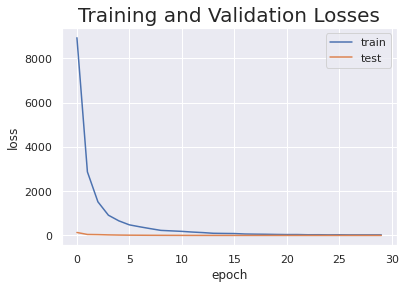

In [64]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [65]:
X_train_trm = emb_model.predict(X_train.reshape(-1, sent_emb, 1))
X_test_trm = emb_model.predict(X_test.reshape(-1, sent_emb, 1))
X_train.shape, X_train_trm.shape, X_test.shape, X_test_trm.shape

((2153, 7), (2153, 7), (539, 7), (539, 7))

In [66]:
# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne = tsne.fit_transform(X_train)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)

In [67]:
train_tsne.shape, train_tsne_embeds.shape

((2153, 2), (2153, 2))

(2153, 2) (2153,)


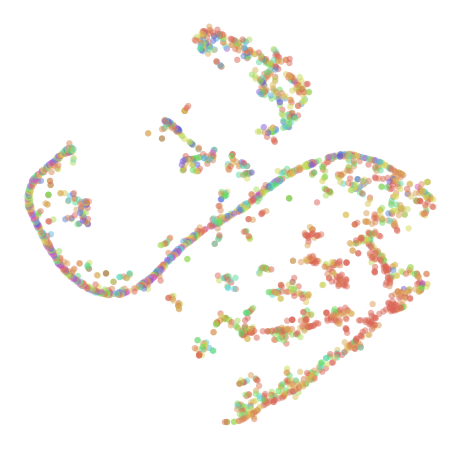

In [68]:
def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 500))
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40, c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
print(train_tsne.shape, y_train.shape)
scatter(train_tsne, y_train)

(2153, 2) (2153,)


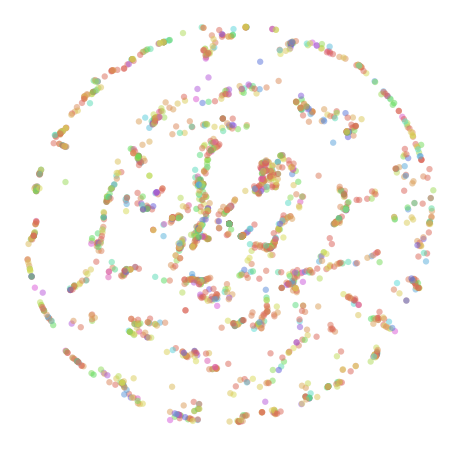

In [69]:
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

# Classify

In [70]:
import pandas as pd
import numpy as np
from copy import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pymedtermino

from metric_learn import NCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from tpot import TPOTClassifier

generations = 3
population_size = 100
max_eval_time_mins = 2
n_jobs = 10
max_iter = 10

tpot = TPOTClassifier(generations=generations, 
                      population_size=population_size,
                      verbosity=2, 
                      random_state=42, 
                      max_eval_time_mins=max_eval_time_mins, 
                      n_jobs=n_jobs)

tpot.fit(X_train_trm, y_train)
score = tpot.score(X_test_trm, y_test)

Optimization Progress:   0%|          | 0/400 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.11054335509631467

Generation 2 - Current best internal CV score: 0.11054335509631467

Generation 3 - Current best internal CV score: 0.11054335509631467

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=9, min_samples_leaf=1, min_samples_split=7)


In [71]:
score

0.11873840445269017

score was with low alpha = 0.17439703153988867
score was with 0.2 alpha = 0.11873840445269017

In [55]:
y = np.array([2, 3 , 4, 5, 1, 2, 0 ,1, 2])
d = np.array([324, 656, 55453, 2342, 5464, 3244, 23, 545, 23243])

y[np.argmin(d)]

0

In [ ]:
y = np.array([1, 2, 2, 1, 0 ,0 ,0, 1]*3)
d = np.array([2333, 232, 13423, 32423 ,234324, 234, 4545, 23]*3)

np.argpartition(d, y.shape[0]-1)[:], y[np.argpartition(d, y.shape[0]-1)[:]]

In [ ]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

In [ ]:
# from google.colab import files
# import io
# uploaded = files.upload()


In [ ]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])